## Recitation 06: sampling distributions, the Central Limit Theorem , and bootstrapping

### The data
We'll explore a dataset presented by the NY Times about adherence to a specific non-pharmaceutical intervention (NPI): mask wearing. 
Covering your mouth and nose with a mask protects against respiratory infections.
This includes SARS-COV-2, the virus that causes COVID-19.

But our attitudes towards the pandemic, our cultural beliefs, and even our political views impact how frequently we wear a mask. 

The NY Times reported this data and an analysis [here](https://www.nytimes.com/interactive/2020/07/17/upshot/coronavirus-face-mask-map.html), and in that article they say how the data was collected:

*Our data comes from a large number of interviews conducted by the global data and survey firm Dynata at the request of The New York Times. The firm asked a question about mask use to obtain 250,000 survey responses between July 2 and July 14, enough data to provide estimates more detailed than the state level. (Several states have imposed new mask requirements since the completion of these interviews.)*

### Our goals

Our goals will be to better understand 
* Distributions of values from a r.v. versus sampling distributions of statistics
* How the Central Limit Theorem (CLT) can be a good approximation to the mean
* Limitations to the CLT
* An alternative technique to learning about a sampling distribution---bootstrapping

### Load the data into Jupyter. 

The dataset is stored on GitHub and open to the public.
The link to the GitHub repo is https://github.com/nytimes/covid-19-data/blob/master/mask-use/README.md , and we can use the pandas module to download the data. 

In [141]:
# import pandas module and nickname it pd
import pandas as pd 

# Load in the data. 
d = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/mask-use/mask-use-by-county.csv")

# Count the number of counties surveyed
numberOfCounties = len(d)

# Nice link to learn about the .format function you can use with strings: https://pyformat.info/
print("Number of Counties surveyed {:d}".format(numberOfCounties))

Number of Counties surveyed 3142


# Define Target population and Observations

Our target **population** is all counties in the US, and a **sample** is a set of counties. 
For each county researchers asked participants how often they wear a mask. 
Participants would select one of five answers: never, rarely, sometimes, frequently, or always. 

A sampled dataset (**data matrix**) contains counties as rows, one variable identifying the county, and five variables of the frequency of mask usage.
For example, 

In [142]:
print(d.head(3)) # the .head function, when used on a pandas dataframe, prints 5 rows by default.

   COUNTYFP  NEVER  RARELY  SOMETIMES  FREQUENTLY  ALWAYS
0      1001  0.053   0.074      0.134       0.295   0.444
1      1003  0.083   0.059      0.098       0.323   0.436
2      1005  0.067   0.121      0.120       0.201   0.491


## Distribution of Mask Wearing (observation level)

We can define $5$ continuous random variables corresponding to the fraction of participants that responded never, rarely, sometimes, frequently, and always.
All five r.v.s will take values from 0 to 1 inclusive. 
To better understand the distribution of these five random variables, lets plot our data two different ways

### Histograms (wide data)

Data sets are called "wide" when several columns of a dataset coukld be considered levels of a single variable.
Our data set is "wide" because the columns "NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", and "ALWAYS" could be considered levels of a single variable called (for example) "frequency". 

Below, we will setup a plot that contains 5 frames. 

Mask wearing Frequency = NEVER
Mask wearing Frequency = RARELY
Mask wearing Frequency = SOMETIMES
Mask wearing Frequency = FREQUENTLY
Mask wearing Frequency = ALWAYS


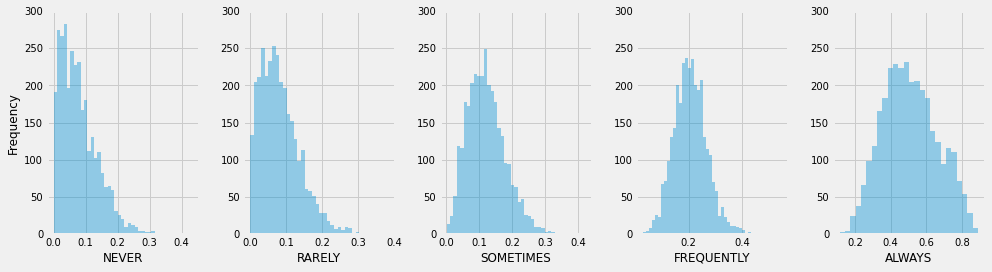

In [143]:
import matplotlib.pyplot as plt  # matplotlib module
import seaborn as sns            # seaborn plotting library

plt.style.use("fivethirtyeight") # this setups some nice plot graphics.
fig,axs = plt.subplots(1,5)      # this generates a plot with 5 frames

# We can iterate through the five different levels of mask wearing frequency and do the following:
# 1. Plot a histogram using the seaborn module
# 2. Reduce the size of the ticklabels
# 3. Set the ylanel for the first plot (farthest left)
# 4. After the loop, set the size of the figure.

i=0
for freq in ["NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]: # 5 frequencies of mask wearing
    print("Mask wearing Frequency = {:s}".format(freq))
    
    # The loc function allows the user to subset a pandas dataframe.
    # The first argument is for the rows to select and the second argument is for columns
    # The first input is a list of Trues and Falses that corresponds to which 
    # values to keep (True) and which to leave (False).
    # The second input is a list of strings that corresponds to which columns to keep.
    # More on the loc function is here:
    # 1. https://towardsdatascience.com/loc-and-iloc-functions-in-pandas-aea7f775de2a
    # 2. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html
    # 3. https://www.w3resource.com/pandas/dataframe/dataframe-loc.php
    
    maskWearing = d.loc[:,freq] # pick all rows (the :) and a single column that is the value of freq
    sns.distplot(maskWearing,ax=axs[i],kde=False)               # distplot in seaborn plots a histogram
    
    ax = axs[i] # axs is a list of each of the five plotting windows.
    ax.tick_params(labelsize=10) # change the size of the tick labels
    
    # If the first plot is selcted then add a ylabel
    if i==0:
        ax.set_ylabel("Frequency",fontsize=12)
    ax.set_xlabel(freq,fontsize=12) # Add a xlabel 
    ax.set_ylim(0,300) # set the vertical limits of each plot from 0 to 300
    
    i+=1 # advance i by 1

fig.set_size_inches(14,4)  # Set the size of the figure
fig.set_tight_layout(True) # Tight layout to true (an algorithm that makes propoer space for all your plots)
plt.show()                 # Show us the plot

###  Boxplot (long data)

A lot of functions, including the boxplot function in seaborn, as you to transform your data to long format.
Unlike wide data, long data has all levels that correspond to a single variable incorporated into one variable.

For example, our data can be made long if there is a variable that includes all levels of mask wearing frequency.
Our wide data looked like:

In [144]:
print(d.head(5))

   COUNTYFP  NEVER  RARELY  SOMETIMES  FREQUENTLY  ALWAYS
0      1001  0.053   0.074      0.134       0.295   0.444
1      1003  0.083   0.059      0.098       0.323   0.436
2      1005  0.067   0.121      0.120       0.201   0.491
3      1007  0.020   0.034      0.096       0.278   0.572
4      1009  0.053   0.114      0.180       0.194   0.459


The [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html) function allows the user to change data from wide to long. 

In [145]:
longData = pd.melt(d,id_vars=['COUNTYFP']) # from wide to long data
print(longData.head())

   COUNTYFP variable  value
0      1001    NEVER  0.053
1      1003    NEVER  0.083
2      1005    NEVER  0.067
3      1007    NEVER  0.020
4      1009    NEVER  0.053


[Text(0, 0, 'Never'),
 Text(0, 0, 'Rarely'),
 Text(0, 0, 'Sometimes'),
 Text(0, 0, 'Frequently'),
 Text(0, 0, 'Always')]

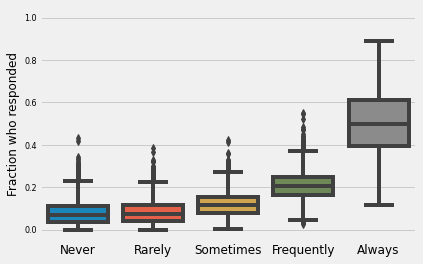

In [146]:
fig,ax = plt.subplots() # create a figure
sns.boxplot( x = "variable" , y = "value" , data  = longData) # boxplot

ax.set_xlabel("")

ax.set_ylabel("Fraction who responded",fontsize=12)
ax.set_ylim(-0.05,1.05)

ax.tick_params(labelsize=8)

ax.set_xticklabels(["Never","Rarely","Sometimes","Frequently","Always"],fontsize=12)

### Distribution of average fraction who responded in each of the five categories

The distribution of a statistic is called a **sampling distribution**. 
We'll explore the sampling distribution of the mean, median, and standard deviation of the fraction of participants who said they never, rarely, sometimes, frequently, and always wear a mask. 

We know from the Central Limit Theorem (CLT) the distribution of the mean is likely well approximated by a Normal distribution. The normal distribution is parameterized by the average of our data and the standard deviation divided by the square root of the number of samples---the standard error. 

In [147]:
# We'll keep track of the mean, standard deviation, and the standard error with three different lists 
avgs     = []
stdDevs  = []
stdErrors = []

# Loop through the five different frequencies
for freq in ["NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]:
    fractions = d.loc[:,freq].values         # subset to the mask wearing frequency contained in the var "freq" 
    numberOfResponses = len(fractions)       # compute the number of observations 
    
    avg      = np.mean(fractions)           # compute the mean using numpy
    avgs.append(avg)                        # append the mean to our list avgs
    
    stdDev   = np.std(fractions)            # compute the standrad deviation
    stdDevs.append(stdDev)                  # append the standard deviation to our list
    
    stdError = stdDev / np.sqrt(numberOfResponses) # compute the standard error!
    stdErrors.append(stdError)                     # append the standard error to our list
    
print("Number of Responses") # Print the total number of responses
print(numberOfResponses) 
     
print("Averages")                     # Print the 5 different averages
roundedAvgs = np.round(avgs,3)        # Round to 3 decimal places
print(roundedAvgs)

print("Standard Deviations")          # Print the 5 standard deviations
roundedSDs = np.round( stdDevs, 3 )   # Round to 3 decimal places
print(roundedSDs)

print("Standard Errors")              # Print the 5 standard errors
roundedSEs = np.round( stdErrors, 4 ) # Round to 4 decimal places
print(roundedSEs)

Number of Responses
3142
Averages
[0.08  0.083 0.121 0.208 0.508]
Standard Deviations
[0.059 0.055 0.058 0.064 0.152]
Standard Errors
[0.001  0.001  0.001  0.0011 0.0027]


It looks like the following five distributions may well characterize the average fraction of the five different levels of mask wearing. 

\begin{align}
    \text{Never } &\sim \mathcal{N}     \left( 0.080, 1.0 \times 10^{-3} \right) \\ 
    \text{Rarely } &\sim \mathcal{N}    \left( 0.083, 1.0 \times 10^{-3} \right) \\ 
    \text{Sometimes } &\sim \mathcal{N} \left( 0.121, 1.0 \times 10^{-3} \right) \\ 
    \text{Frequently} &\sim \mathcal{N} \left( 0.208, 1.1 \times 10^{-3} \right) \\ 
    \text{Always} &\sim \mathcal{N}     \left( 0.508, 2.7 \times 10^{-3} \right) \\ 
\end{align}

We can plot these five distributions. 

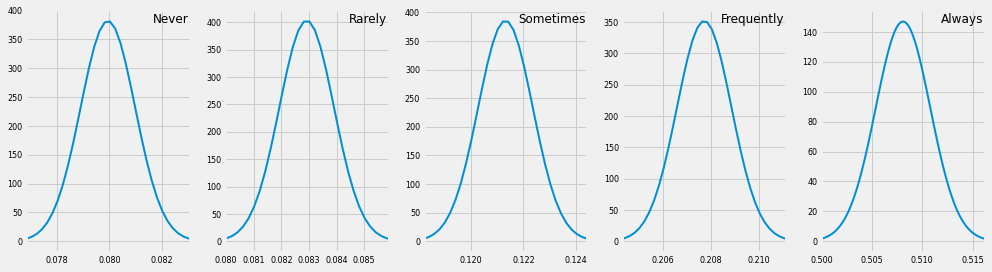

In [169]:
import scipy.stats            # import the scipy.stats module
normalDist = scipy.stats.norm # assign the scipy.stats.norm function to a variable called normalDist 

fig,axs = plt.subplots(1,5)   # Create a figure with five plotting windows

i=0
domain = np.linspace(0,1,5000)  # the fraction of participants ranges from 0 to 1 inclusive. 

# The zip function is new to us. You can zip two lists together so that you can 
# run through 2,3,4,etc list simultaneously
for (f,a,se) in zip(["Never","Rarely","Sometimes","Frequently","Always"],avgs,stdErrors): 
    pdfValues = normalDist(a,se).pdf(domain) # compute the probabiltiy density function for 5,000 vals from 0 to 1
   
    ax = axs[i]
    ax.plot(domain, pdfValues,lw=2 ) # plot the domain and pdfs
    
    ax.set_xlim( a-3*se, a+3*se )   # plot the x-limit 3 SEs to the left and right of the mean
    ax.tick_params(labelsize=8)     # Change the size of the tick labels to 8
    
    ax.text( 0.99 # x coordinate
            ,0.99 # y coordinate
            ,s=f  # The text
            ,ha='right' # the horizontal alignment
            ,va='top'   # the vertical alignment
            ,transform=ax.transAxes # transforms to the fraction of the plotting window (0-1)
            ,fontsize=12
    )
    i+=1
    
fig.set_size_inches(14,4)
fig.set_tight_layout(True)
plt.show()

### Bootstrapping

To better understand sampling distributions and when the CLT is a good approximation, we'll look at a technique called [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)).
Bootstrapping from a dataset $\mathcal{D}$ with $N$ observations generates a sampling distribution for a statistic $f$ by building $S$ datasets with $N$ observations.
Each dataset $S$ is built by sampling (with replacement) observations from the original dataset $\mathcal{D}$.
Datasets $S$ are meant to represent a library of possible datasets you could have collected, and so statistics computed from each randomly generated dataset $S$ represent a distribution of possible statistics---a sampling distribution.

Below is code to generate $5,000$ datasets that are the same size as our original dataset. 
We will compute the mean for each bootstrapped dataset and plot a histogram to represent our sampling distribution.

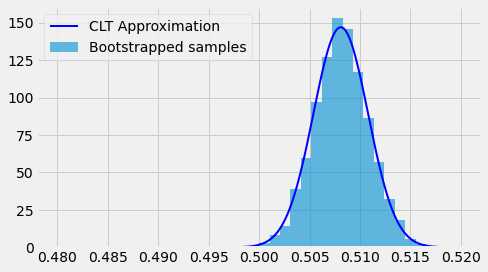

In [172]:
means = []               # an empty list holding our bootstrapped statistics
for i in range(5*10**3): # The number of bootstrap samples
    sampledDataset = d.sample(frac=1., replace=True) # the bootstrap
    mean = np.mean(sampledDataset.ALWAYS)            # compute the mean of the bootstrapped data
    means.append( mean )                             # add the bootstrapped statistic to our list

fig,ax = plt.subplots() # figure

# histogram of bootstrapped statistics (sampling dist)
ax.hist( means,20,density=True, label = "Bootstrapped samples",alpha=0.60 )

# plot the normal distribution we found from the CLT
domain    = np.linspace(0.48,0.52,4000)
pdfValues = normalDist(a,se).pdf(domain)

ax.plot(domain,pdfValues,lw=2, label="CLT Approximation",color="blue")

# Plot the legend
ax.legend()

fig.set_size_inches(7,4)
fig.set_tight_layout(True)
plt.show()

The distribution of the mean fraction who always wear a mask is well approximated by a normal distribution.
This fundamental result in statistic is called the **Central Limit Theorem (CLT)**.
The CLT states the mean can be well approximated by a normal distribution, but that guarantee does not necessarily extend to other statistics. 
Let's look at two additional statistics: the median and standard deviation. 

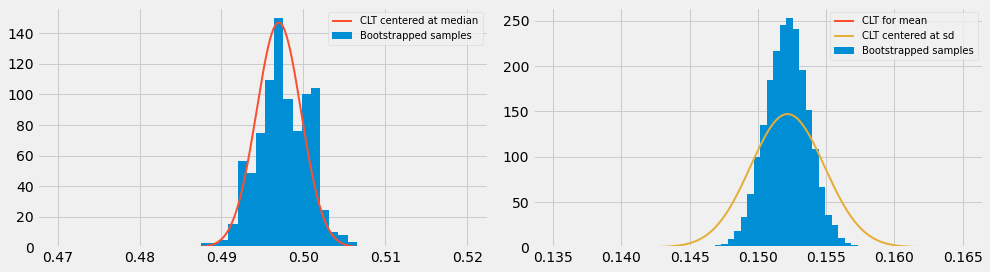

In [173]:
medians = []
sds = []
for i in range(1*10**4):
    sampledDataset = d.sample(frac=1., replace=True)
    median = np.median(sampledDataset.ALWAYS)
    sd     = np.std(sampledDataset.ALWAYS) 
    
    medians.append( median )
    sds.append(sd)

fig,axs = plt.subplots(1,2)

ax = axs[0]
ax.hist(medians,25,density=True, label = "Bootstrapped samples")

domain = np.linspace(0.47,0.52,5000)
pdfValues = normalDist(np.median(d.ALWAYS),se).pdf(domain)
ax.plot(domain,pdfValues,lw=2, label="CLT centered at median")

ax.legend(fontsize=10)

# Second plot of Standrard Deviation
ax = axs[1]
ax.hist(sds,25,density=True, label = "Bootstrapped samples")

ax.plot(domain,pdfValues,lw=2, label="CLT for mean")

domain = np.linspace(0.135,0.165,5000)
pdfValues = normalDist(np.std(d.ALWAYS),se).pdf(domain)
ax.plot(domain,pdfValues,lw=2, label="CLT centered at sd")

ax.legend(fontsize=10)

fig.set_size_inches(14,4)
fig.set_tight_layout(True)
plt.show()

The sampling distribution for the median looks a bit different than normal. 
The standard deviation's sampling distribution looks very normal but the standard error is too big. 

### QSA: Why might the standard deviation look normal but not the median?